In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
import dill
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, Birch, MeanShift, OPTICS
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, ndcg_score
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import NearestNeighbors
from keras.callbacks import Callback
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Activation
from sklearn.metrics.pairwise import euclidean_distances
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from matplotlib_venn import venn2

In [3]:
gs = pd.read_csv('C:\\Users\\user\\Downloads\\ml-latest\\ml-latest\\genome-scores.csv', encoding='ISO-8859-1', low_memory=False)
movies = pd.read_csv('C:\\Users\\user\\Downloads\\ml-latest\\ml-latest\\movies.csv', encoding='ISO-8859-1', low_memory=False)
gt = pd.read_csv('C:\\Users\\user\\Downloads\\ml-latest\\ml-latest\\genome-tags.csv', encoding='ISO-8859-1', low_memory=False)
ratings = pd.read_csv('C:\\Users\\user\\Downloads\\ml-latest\\ml-latest\\ratings.csv', encoding='ISO-8859-1', low_memory=False)
links = pd.read_csv('C:\\Users\\user\\Downloads\\ml-latest\\ml-latest\\links.csv', encoding='ISO-8859-1', low_memory=False)
tags = pd.read_csv('C:\\Users\\user\\Downloads\\ml-latest\\ml-latest\\tags.csv', encoding='ISO-8859-1', low_memory=False)

In [295]:
gs.head()

,movieId,tagId,relevance
0,1,1,0.03200
1,1,2,0.02225
2,1,3,0.07000
3,1,4,0.05900
4,1,5,0.12300


In [296]:
gs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18472128 entries, 0 to 18472127
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 422.8 MB


In [297]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [298]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86537 entries, 0 to 86536
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  86537 non-null  int64 
 1   title    86537 non-null  object
 2   genres   86537 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.0+ MB


In [299]:
gt.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [300]:
gt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagId   1128 non-null   int64 
 1   tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB


In [301]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119


In [302]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33832162 entries, 0 to 33832161
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 1.0 GB


In [303]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [304]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86537 entries, 0 to 86536
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  86537 non-null  int64  
 1   imdbId   86537 non-null  int64  
 2   tmdbId   86411 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.0 MB


In [305]:
tags.head()

,userId,movieId,tag,timestamp
0,10,260,good vs evil,1430666558
1,10,260,Harrison Ford,1430666505
2,10,260,sci-fi,1430666538
3,14,1221,Al Pacino,1311600756
4,14,1221,mafia,1311600746


In [306]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328315 entries, 0 to 2328314
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   userId     int64 
 1   movieId    int64 
 2   tag        object
 3   timestamp  int64 
dtypes: int64(3), object(1)
memory usage: 71.1+ MB


<h3> Создание таблицы popularity для выявления среднего рейтинга на основе ratings

In [4]:
def create_popularity_table():
    movies_path = 'C:\\Users\\user\\Downloads\\ml-latest\\ml-latest\\movies.csv'
    ratings_path = 'C:\\Users\\user\\Downloads\\ml-latest\\ml-latest\\ratings.csv'

    movies = pd.read_csv(movies_path, encoding='ISO-8859-1', low_memory=False)
    ratings = pd.read_csv(ratings_path, encoding='ISO-8859-1', low_memory=False)

    avg_ratings = ratings.groupby("movieId")["rating"].mean().reset_index()
    avg_ratings.columns = ["movieId", "ave_rating"]

    popularity = pd.merge(
        movies[["movieId", "title", "genres"]],
        avg_ratings,
        on="movieId"
    )
    return popularity

In [5]:
# Создание таблицы популярности
popularity = create_popularity_table()

<h3> Топ-10 фильмов по популярности в заданном жанре

In [7]:
def get_top_by_genre(genre: str, popularity_df: pd.DataFrame) -> pd.DataFrame:
    # Разделение жанров и фильтрация по заданному
    exploded = popularity_df.assign(genres=popularity_df["genres"].str.split(r"\|")).explode("genres")
    filtered = exploded[exploded["genres"] == genre]
    # Сортировка по рейтингу и выбор топ-10
    top10 = filtered.sort_values("ave_rating", ascending=False).head(10)
    return top10[["title", "genres", "ave_rating"]]

# топ-10 фильмов по жанру 
print(get_top_by_genre("Drama", popularity))

                                                   title genres  ave_rating
72216                            Backyard Wedding (2010)  Drama         5.0
77814                    The Dove's Lost Necklace (1992)  Drama         5.0
54808                            The Jade Pendant (2017)  Drama         5.0
63343                                 The Deadman (1989)  Drama         5.0
31485                                        About Sarah  Drama         5.0
67845                          Story of a Bad Boy (1999)  Drama         5.0
25330                                  Invitation (1952)  Drama         5.0
79526                                    Pendular (2017)  Drama         5.0
77813                     Wanderers of the Desert (1984)  Drama         5.0
60791  All's Well That Ends Well: Shakespeare's Globe...  Drama         5.0


<h3>  Рекомендации по фильму без учета рейтинга</h3>

In [12]:
# Преобразование жанров в признаки (TF-IDF)
def get_movie_recommendations(movie_title: str, movies_df: pd.DataFrame) -> list:
    tfidf = TfidfVectorizer(
        tokenizer=lambda x: x.split("|"), 
        token_pattern=None
    )
    genres_matrix = tfidf.fit_transform(movies_df["genres"])
    
    # Прямой расчет схожести (без SVD)
    cosine_sim = cosine_similarity(genres_matrix)
    
    idx = movies_df.index[movies_df["title"] == movie_title].tolist()[0]
    sim_scores = sorted(enumerate(cosine_sim[idx]), key=lambda x: x[1], reverse=True)[1:11]
    return movies_df["title"].iloc[[i[0] for i in sim_scores]].tolist()

In [14]:
# Фильтрация фильмов с высокой популярностью
movie_rating_counts = ratings["movieId"].value_counts()
popular_movies = movie_rating_counts[movie_rating_counts > 100].index
movies_filtered = movies[movies["movieId"].isin(popular_movies)]

In [16]:
print(get_movie_recommendations("Toy Story (1995)", movies_filtered))

['Antz (1998)', 'Toy Story 2 (1999)', 'Adventures of Rocky and Bullwinkle, The (2000)', "Emperor's New Groove, The (2000)", 'Monsters, Inc. (2001)', 'DuckTales: The Movie - Treasure of the Lost Lamp (1990)', 'Wild, The (2006)', 'Shrek the Third (2007)', 'Tale of Despereaux, The (2008)', 'Asterix and the Vikings (AstÃ©rix et les Vikings) (2006)']


<h3> Подготовка данных</h3>

In [18]:
# Преобразуем genome_scores в широкую таблицу: movieId × tagId
movie_tag_matrix = gs.pivot(index='movieId', columns='tagId', values='relevance').fillna(0)

# Добавим к movie_tag_matrix названия тегов
tag_id_to_name = gt.set_index('tagId')['tag']
movie_tag_matrix.columns = movie_tag_matrix.columns.map(tag_id_to_name)

# Проверим результат
print("movie_tag_matrix shape:", movie_tag_matrix.shape)
movie_tag_matrix.head(3)

movie_tag_matrix shape: (16376, 1128)


tagId,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0320,0.02225,0.07000,0.05900,0.12300,0.1310,0.06175,0.19550,0.26625,0.03300,...,0.04125,0.01550,0.03775,0.03500,0.11525,0.04350,0.04050,0.03300,0.07700,0.01825
2,0.0325,0.03200,0.04050,0.05100,0.10050,0.0635,0.19825,0.07525,0.09750,0.06325,...,0.04100,0.02025,0.01100,0.01875,0.13425,0.01850,0.01825,0.00825,0.08750,0.01375
3,0.0415,0.05525,0.02125,0.07225,0.05125,0.0440,0.03000,0.10375,0.02300,0.03250,...,0.06175,0.01825,0.02375,0.01700,0.12400,0.02775,0.01600,0.01325,0.10075,0.01800


<h3> Autoencoder + кластеризация</h3>

In [20]:
# Нормализация
scaler = MinMaxScaler()
movie_vectors_scaled = scaler.fit_transform(movie_tag_matrix)

print("Scaled shape:", movie_vectors_scaled.shape)

Scaled shape: (16376, 1128)


In [22]:
input_dim = movie_vectors_scaled.shape[1]
encoding_dim = 32  # Сжатие до 32 признаков

input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)

# Обучение
autoencoder.compile(optimizer=Adam(1e-3), loss='mse')

autoencoder.fit(
    movie_vectors_scaled, movie_vectors_scaled,
    epochs=100, batch_size=256,
    shuffle=True, verbose=1
)

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0944 
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0232 
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0168 
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0128 
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0116 
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0107 
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099 
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092 
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0087 
Epoch 10/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083 
Epoch 11/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0079 
Epoch 12/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076 
Epoch 13/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074 
Epoch 14/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 
Epoch 15/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - los

In [24]:
# Режиме инференса
encoded_movies = encoder.predict(movie_vectors_scaled)

512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step


In [26]:
# Spectral Clustering
sc = SpectralClustering(n_clusters=10, affinity='nearest_neighbors')
labels = sc.fit_predict(encoded_movies)
print("Spectral Clustering:", silhouette_score(encoded_movies, labels))

Spectral Clustering: 0.062341508


In [401]:
# KMeans
kmeans = KMeans(n_clusters=150, random_state=42)
kmeans_labels = kmeans.fit_predict(encoded_movies)
print("KMeans Silhouette:", silhouette_score(encoded_movies, kmeans_labels))

KMeans Silhouette: 0.067771606


In [324]:
# DBSCAN
dbscan = DBSCAN(eps=2.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(encoded_movies)

In [325]:
print("Кластеры DBSCAN:", np.unique(dbscan_labels, return_counts=True))

Кластеры DBSCAN: (array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39], dtype=int64), array([13546,  2479,    28,    11,    10,    12,     7,    13,     4,
          15,     8,    10,     6,     4,     6,     6,    26,     9,
          11,     6,     5,     4,     7,     5,     4,     5,    13,
          16,     6,     5,    23,     5,     5,    17,     6,     5,
           5,     7,     5,     7,     4], dtype=int64))


In [326]:
for eps in [0.5, 1.0, 1.5, 2.0]:
    db = DBSCAN(eps=eps, min_samples=5).fit(encoded_movies)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"eps={eps}: кластеры={n_clusters}, шум={np.sum(labels == -1)}")

eps=0.5: кластеры=0, шум=16376
eps=1.0: кластеры=0, шум=16376
eps=1.5: кластеры=4, шум=16339
eps=2.0: кластеры=15, шум=15700


In [44]:
# Agglomerative
agg = AgglomerativeClustering(n_clusters=3)
agg_labels = agg.fit_predict(encoded_movies)
print("Agglomerative Silhouette:", silhouette_score(encoded_movies, agg_labels))

Agglomerative Silhouette: 0.12224434


In [328]:
# Birch clustering
birch = Birch(n_clusters=3)
birch_labels = birch.fit_predict(encoded_movies)
print("Birch clustering:", silhouette_score(encoded_movies, birch_labels))

Birch clustering: 0.08013917


In [329]:
# OPTICS clustering
optics = OPTICS(min_samples=3)
optics_labels = optics.fit_predict(encoded_movies)
print("OPTICS clusterin:", silhouette_score(encoded_movies, optics_labels))

OPTICS clusterin: -0.4613854


In [330]:
# Gaussian Mixture Model clustering
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(encoded_movies)
print("Gaussian Mixture Model clustering:", silhouette_score(encoded_movies, gmm_labels))

Gaussian Mixture Model clustering: 0.020435082


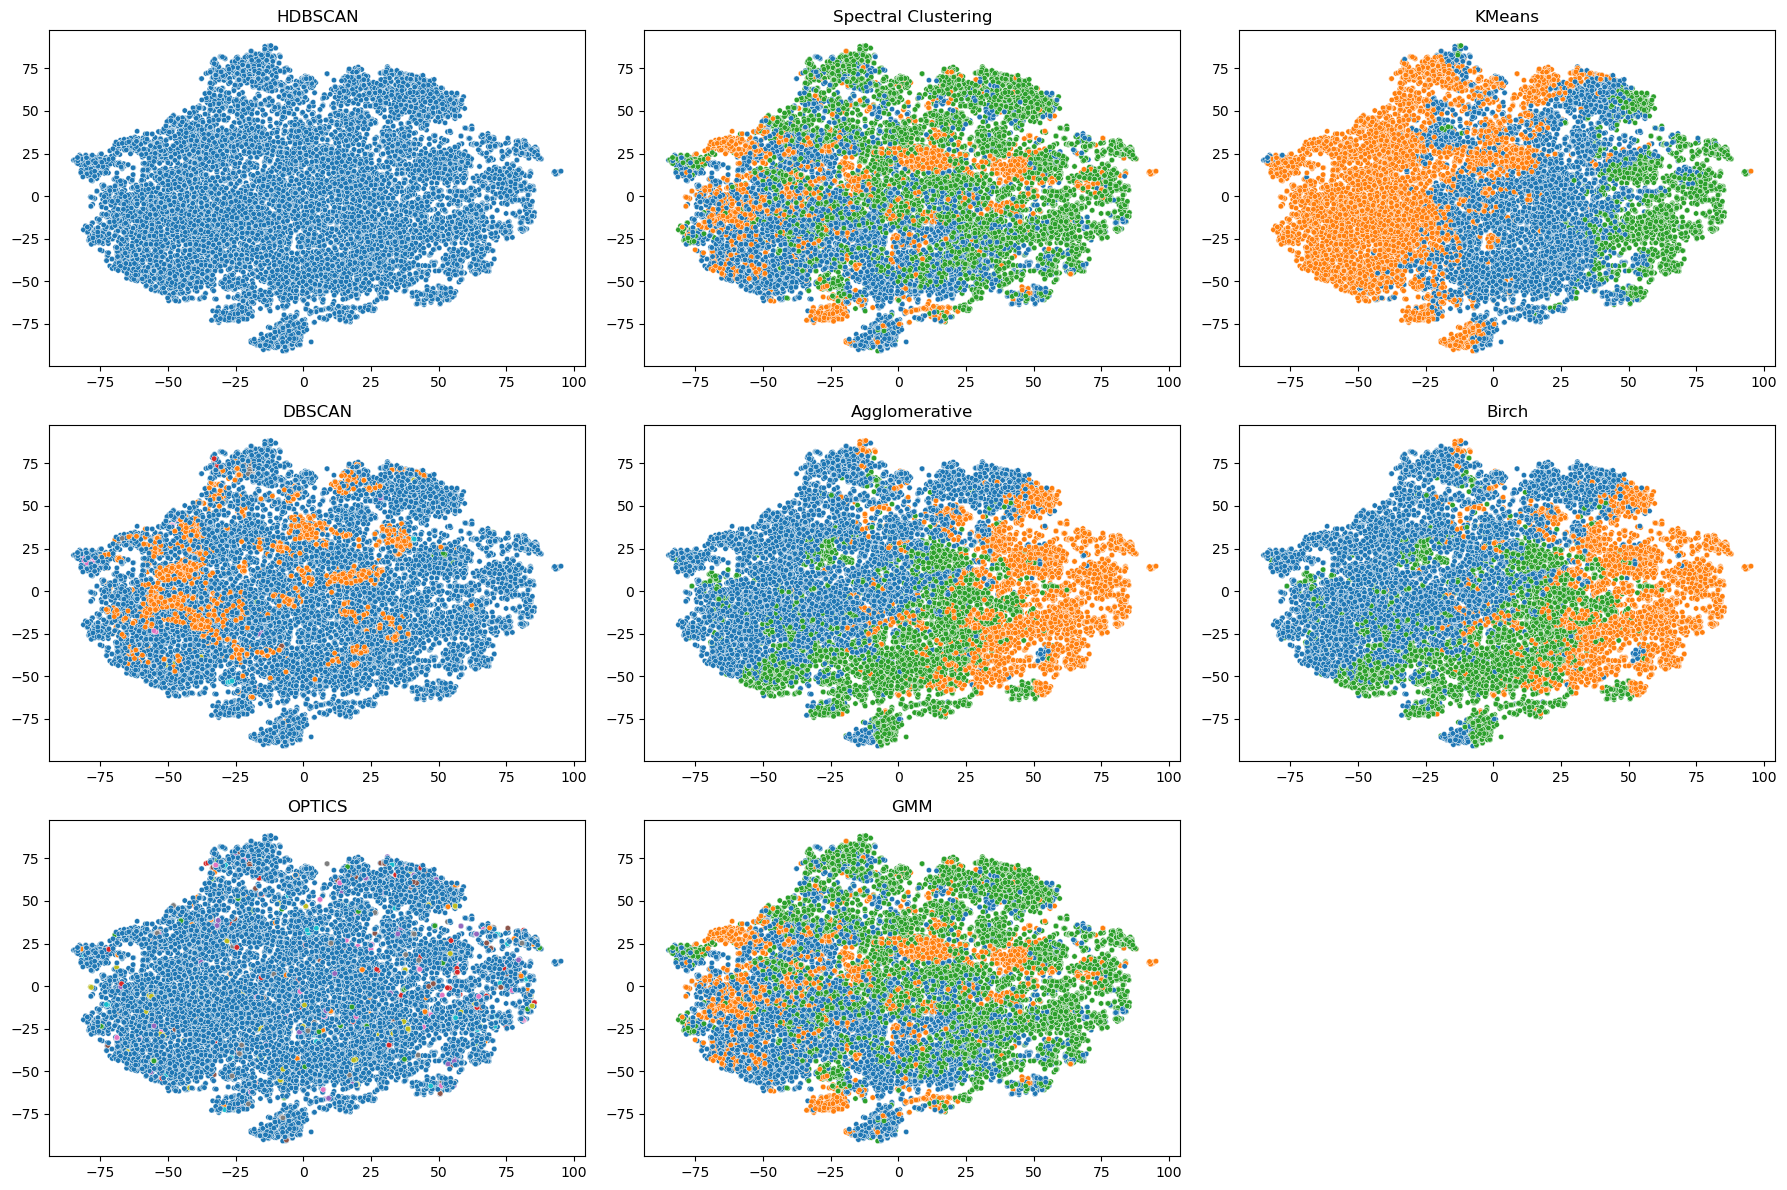

In [396]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced = tsne.fit_transform(encoded_movies)

# Визуализация
plt.figure(figsize=(18, 12))

clusterings = [
    ("HDBSCAN", hdblabels),
    ("Spectral Clustering", labels),
    ("KMeans", kmeans_labels),
    ("DBSCAN", dbscan_labels),
    ("Agglomerative", agg_labels),
    ("Birch", birch_labels),
    ("OPTICS", optics_labels),
    ("GMM", gmm_labels)
]

for i, (title, labels) in enumerate(clusterings, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=labels, palette='tab10', s=15, legend=False)
    plt.title(title)

plt.tight_layout()
plt.show()

Анализируя все графики можно сказать, что KMeans, Agglomerative Clustering и Birch делит данные достаточно сбалансированно. Agglomerative Clustering и  Birch почти идентичны, скорее всего это связано с тем, что оба метода работают на иерархической кластеризации. Цвета распределены по зонам, что говорит о хорошей сегментации, что не скажешь про HDBSCAN, DBSCAN, OPTICS и Spectral Clustering. В основном там одни шумы, а значит такие методы не особо и подходят для данного датасета, либо можно подобрать другие параметры и попробовать еще раз по эксперементировать. Метод GMM не плох, но видно, что есть перекрытие. Это ожидаемо, т.к. GMM даёт размягчённое разбиение (вероятностное), а не жёсткое.

<h3>Content-based + Similarity

In [30]:
# Вычислим матрицу косинусного сходства
similarity_matrix = cosine_similarity(encoded_movies)

# Функция для рекомендаций по ID фильма
def recommend_similar_movies(movie_id, movies_df, similarity_matrix, top_n=10):
    # Получаем индекс фильма в матрице
    try:
        idx = movies_df[movies_df['movieId'] == movie_id].index[0]
    except IndexError:
        print("Фильм с таким ID не найден.")
        return pd.DataFrame()

    # Получаем вектор похожести
    sim_scores = list(enumerate(similarity_matrix[idx]))

    # Сортируем по убыванию похожести, исключая сам фильм
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]

    # Получаем индексы похожих фильмов
    movie_indices = [i[0] for i in sim_scores]

    # Возвращаем DataFrame с результатами
    return movies_df.iloc[movie_indices][['movieId', 'title', 'genres']].reset_index(drop=True)

# Вывод рекомендации по фильму 
recommended = recommend_similar_movies(1, movies, similarity_matrix)
print("Рекомендованные фильмы:")
print(recommended)

Рекомендованные фильмы:
   movieId                                              title  \
0     4533              Return of the Living Dead, The (1985)   
1     2196                                   Knock Off (1998)   
2    44655  Trial of Joan of Arc, The (ProcÃ¨s de Jeanne d...   
3     2912                                  Limey, The (1999)   
4     5786                                Paid in Full (2002)   
5    27003                                     Beowulf (1999)   
6     2578                 Sticky Fingers of Time, The (1997)   
7    59143                               Super High Me (2007)   
8     3994                                 Unbreakable (2000)   
9    81366               Only Son, The (Hitori musuko) (1936)   

                 genres  
0  Comedy|Horror|Sci-Fi  
1                Action  
2             Drama|War  
3  Crime|Drama|Thriller  
4          Action|Drama  
5  Action|Horror|Sci-Fi  
6                Sci-Fi  
7    Comedy|Documentary  
8          Drama|Sci-Fi  


<h1> User-based</h1>

In [36]:
def get_user_vector(user_id, viewed_movie_ids, ratings_df, movie_vectors, movie_id_map, rating_threshold=4.0):
    """
    Строит user_vector в зависимости от количества рейтингов и их качества.
    
    Параметры:
    - user_id: ID пользователя
    - viewed_movie_ids: список просмотренных movieId (может включать фильмы без оценки)
    - ratings_df: DataFrame с колонками ['userId', 'movieId', 'rating']
    - movie_vectors: массив векторов фильмов 
    - movie_id_map: словарь movieId → индекс в movie_vectors
    - rating_threshold: рейтинг, выше которого считается "положительный"
    
    Возвращает:
    - user_vector: numpy-вектор предпочтений пользователя
    - mode: 'view_based' или 'rating_based' (для дальнейшей логики)
    """

    for movie_id in viewed_movie_ids:
        original_movie_row = movies[movies['movieId'] == movie_id]
        if original_movie_row.empty:
            continue
        
        original_movie_title = original_movie_row['title'].values[0]
        original_movie_genres = original_movie_row['genres'].values[0]
        original_genres_set = set(original_movie_genres.split('|'))
    
        print(f"Получаем рекомендации для фильма с ID: {movie_id} (Название: {original_movie_title}) (Жанры: {original_movie_genres})")

    user_ratings = ratings_df[ratings_df['userId'] == user_id]
    rated_movie_ids = set(user_ratings['movieId'])
    positive_ratings = user_ratings[user_ratings['rating'] >= rating_threshold]
    
    # Используем рейтинговую стратегию, если достаточно данных
    if len(user_ratings) >= 5 and len(positive_ratings) >= 3:
        vectors = []
        weights = []
        for _, row in user_ratings.iterrows():
            mid = row['movieId']
            if mid in movie_id_map:
                vectors.append(movie_vectors[movie_id_map[mid]])
                weights.append(row['rating'])  # Вес = рейтинг
        if vectors:
            weighted_avg = np.average(vectors, axis=0, weights=weights)
            return weighted_avg, 'rating_based'
    else:
        # Используем просмотренные фильмы
        vectors = []
        for mid in viewed_movie_ids:
            if mid in movie_id_map:
                vectors.append(movie_vectors[movie_id_map[mid]])
        if vectors:
            avg_vector = np.mean(vectors, axis=0)
            return avg_vector, 'view_based'
    
    return None, 'no_data'

In [32]:
def recommend_for_user(user_vector, movie_vectors, movies_df, clustering_labels=None, top_n=10, mode='cosine'):
    """
    Делает рекомендации на основе вектора пользователя тремя способами:
    - mode='cosine': простое косинусное сходство
    - mode='knn': KNN по user_vector
    - mode='cluster': рекомендации из кластера пользователя

    Параметры:
    - user_vector: numpy-вектор предпочтений пользователя
    - movie_vectors: матрица векторов фильмов
    - movies_df: DataFrame с колонками ['movieId', 'title', 'genres']
    - clustering_labels: массив меток кластеров для каждого фильма (нужен для mode='cluster')
    - top_n: количество рекомендаций
    - mode: 'cosine' | 'knn' | 'cluster'

    Возвращает:
    - DataFrame с колонками ['movieId', 'title', 'genres', 'score']
    """


    if user_vector is None:
        return pd.DataFrame(columns=['movieId', 'title', 'genres', 'score'])

    if mode == 'cosine':
        similarities = cosine_similarity([user_vector], movie_vectors)[0]
        top_indices = similarities.argsort()[::-1][:top_n]
        scores = similarities[top_indices]

    elif mode == 'knn':
        knn = NearestNeighbors(n_neighbors=top_n, metric='cosine')
        knn.fit(movie_vectors)
        distances, indices = knn.kneighbors([user_vector])
        top_indices = indices[0]
        scores = 1 - distances[0]  # cos-дистанция -> сходство

    elif mode == 'cluster':
        if clustering_labels is None:
            raise ValueError("Для кластеризации необходимо передать clustering_labels")

        from sklearn.metrics.pairwise import euclidean_distances
        # Определяем ближайший кластер
        cluster_id = clustering_labels[np.argmin(euclidean_distances([user_vector], movie_vectors))]
        cluster_indices = np.where(clustering_labels == cluster_id)[0]
        cluster_vectors = movie_vectors[cluster_indices]

        similarities = cosine_similarity([user_vector], cluster_vectors)[0]
        top_indices_in_cluster = similarities.argsort()[::-1][:top_n]
        top_indices = cluster_indices[top_indices_in_cluster]
        scores = similarities[top_indices_in_cluster]

    else:
        raise ValueError("Неверный mode. Используйте: 'cosine', 'knn', 'cluster'")

    result_df = movies_df.iloc[top_indices].copy()
    result_df['score'] = scores
    return result_df[['movieId', 'title', 'genres', 'score']]

In [40]:
def ensemble_user_recommendations(user_vector, movie_vectors, movies_df, clustering_labels=None, top_n=10):
    """
    Собирает рекомендации из 3 методов: cosine, knn, cluster → делает ensemble.
    
    Возвращает top_n рекомендаций по объединённому score.
    """

   

    rec_cosine = recommend_for_user(user_vector, movie_vectors, movies_df, mode='cosine', top_n=top_n * 2)
    rec_knn = recommend_for_user(user_vector, movie_vectors, movies_df, mode='knn', top_n=top_n * 2)
    rec_cluster = recommend_for_user(user_vector, movie_vectors, movies_df, clustering_labels=clustering_labels, mode='cluster', top_n=top_n * 2)

    # Объединяем все рекомендации
    all_recs = pd.concat([rec_cosine, rec_knn, rec_cluster], axis=0)

    # Суммируем score по movieId
    combined = (
        all_recs.groupby('movieId')
        .agg({
            'score': 'sum',
            'title': 'first',
            'genres': 'first'
        })
        .reset_index()
    )

    # Сортируем и выбираем топ-N
    combined = combined.sort_values('score', ascending=False).head(top_n)
    return combined[['movieId', 'title', 'genres', 'score']]

In [46]:
user_vector, mode = get_user_vector(
    user_id=1,
    viewed_movie_ids=[1, 10, 100],
    ratings_df=ratings,
    movie_vectors=encoded_movies,
    movie_id_map={mid: idx for idx, mid in enumerate(movies['movieId'])}
)
final_recommendations = ensemble_user_recommendations(
    user_vector,
    encoded_movies,
    movies,
    clustering_labels=agg_labels,
    top_n=10
)
final_recommendations

Получаем рекомендации для фильма с ID: 1 (Название: Toy Story (1995)) (Жанры: Adventure|Animation|Children|Comedy|Fantasy)
Получаем рекомендации для фильма с ID: 10 (Название: GoldenEye (1995)) (Жанры: Action|Adventure|Thriller)
Получаем рекомендации для фильма с ID: 100 (Название: City Hall (1996)) (Жанры: Drama|Thriller)


,movieId,title,genres,score
23,85618,Noah's Ark (1928),Drama|War,2.991168
15,82673,Unmade Beds (2009),Comedy|Drama,2.990038
17,83837,"Electric House, The (1922)",Comedy,2.985965
18,84178,Jew SÃ¼ss (Jud SÃ¼Ã) (1940),Drama,2.985374
24,86190,Hanna (2011),Action|Adventure|Mystery|Thriller,2.985210
5,78122,Peter & the Wolf (2006),Animation|Musical,2.984726
11,81027,Autumn Ball (SÃ¼gisball) (2007),Drama,2.984194
7,79897,Get Low (2009),Comedy|Drama|Mystery,2.983910
2,5409,Rapid Fire (1992),Action,2.982988
13,82141,"Brotherhood, The (1968)",Crime|Drama,2.982939


In [48]:
# Сохраняем DataFrame
with open('final_recommendations.dill', 'wb') as f:
    dill.dump(final_recommendations, f)

<h1> Гибридный подход</h1>

In [50]:
def hybrid_recommendations(
    user_vector,
    movie_vectors,
    movies_df,
    content_reference_ids,
    movie_id_map,
    clustering_labels=None,
    top_n=10,
    content_weight=0.5,
    user_weight=0.5
):
    """
    Возвращает рекомендации, объединяя content-based и user-based подходы.

    Параметры:
    - user_vector: вектор предпочтений пользователя
    - movie_vectors: матрица векторов фильмов
    - movies_df: DataFrame с фильмами
    - content_reference_ids: список movieId, на основе которых делать content-based рекомендации
    - movie_id_map: словарь movieId -> индекс
    - clustering_labels: метки кластеров
    - top_n: сколько фильмов вернуть
    - content_weight: вес content-based рекомендаций
    - user_weight: вес user-based рекомендаций

    Возвращает:
    - DataFrame с рекомендациями
    """
    
    # Content-based рекомендации
    content_vectors = []
    for mid in content_reference_ids:
        if mid in movie_id_map:
            content_vectors.append(movie_vectors[movie_id_map[mid]])
    
    if content_vectors:
        content_vector = np.mean(content_vectors, axis=0)
        content_scores = cosine_similarity([content_vector], movie_vectors)[0]
    else:
        content_scores = np.zeros(len(movie_vectors))

    # User-based рекомендации
    if user_vector is not None:
        user_scores = cosine_similarity([user_vector], movie_vectors)[0]
    else:
        user_scores = np.zeros(len(movie_vectors))

    # Гибридные оценки
    final_scores = content_weight * content_scores + user_weight * user_scores

    # Получаем топ-N
    top_indices = final_scores.argsort()[::-1][:top_n]
    top_scores = final_scores[top_indices]

    recommendations = movies_df.iloc[top_indices].copy()
    recommendations['score'] = top_scores
    return recommendations[['movieId', 'title', 'genres', 'score']]

In [52]:
hybrid_recs = hybrid_recommendations(
    user_vector=user_vector,
    movie_vectors=encoded_movies,
    movies_df=movies,
    content_reference_ids=[1, 10, 100],
    movie_id_map={mid: idx for idx, mid in enumerate(movies['movieId'])},
    top_n=10,
    content_weight=0.4,
    user_weight=0.6
)
hybrid_recs

,movieId,title,genres,score
16167,85334,Hard Ticket to Hawaii (1987),Action|Comedy,0.988015
16213,85618,Noah's Ark (1928),Drama|War,0.987704
16288,86190,Hanna (2011),Action|Adventure|Mystery|Thriller,0.987418
16374,86593,African Cats (2011),Adventure|Documentary,0.987378
13693,70924,Voices (1979),Drama|Romance,0.987233
15302,80759,Hardcore (2004),Crime|Drama,0.987217
5302,5409,Rapid Fire (1992),Action,0.986958
15106,79897,Get Low (2009),Comedy|Drama|Mystery,0.986824
15033,79592,"Other Guys, The (2010)",Action|Comedy,0.986473
15050,79656,"Great Caruso, The (1951)",Drama|Musical,0.986361


<h1> Ранжирование фильмов</h1>

In [344]:
def apply_bias_with_weights(recommendations_df, bias_dict, movies_df=None, max_boost=1.0):
 
    recommendations_df = recommendations_df.copy()

    for mid, bias in bias_dict.items():
        if mid in recommendations_df['movieId'].values:
            # Фильм уже есть в рекомендациях — применим правило
            if bias == 1.0:
                recommendations_df.loc[recommendations_df['movieId'] == mid, 'score'] = 5.0
            elif bias == 0.5:
                recommendations_df.loc[recommendations_df['movieId'] == mid, 'score'] = 3.0
            elif bias == -1.0:
                recommendations_df.loc[recommendations_df['movieId'] == mid, 'score'] = 0.0
            else:
                recommendations_df.loc[recommendations_df['movieId'] == mid, 'score'] += bias * max_boost
        else:
            # Фильм отсутствует в рекомендациях — добавим из movies_df
            if movies_df is not None and bias > 0:
                movie_row = movies_df[movies_df['movieId'] == mid]
                if not movie_row.empty:
                    title = movie_row['title'].values[0]
                    genres = movie_row['genres'].values[0]
                    score = 5.0 if bias == 1.0 else 3.0

                    new_row = pd.DataFrame([{
                        'movieId': mid,
                        'title': title,
                        'genres': genres,
                        'score': score
                    }])
                    recommendations_df = pd.concat([new_row, recommendations_df], ignore_index=True)

    recommendations_df = recommendations_df.sort_values('score', ascending=False).reset_index(drop=True)
    return recommendations_df

In [345]:
bias_weights = {
    220: 1.0,     
    100: 0.5,    
    10: -1.0,    
    200: -0.5    
}

final_biased_recs = apply_bias_with_weights(final_recommendations, bias_weights, movies, max_boost=1.5)

In [346]:
# До и после
print(" Топ рекомендаций ДО применения bias:")
print(final_recommendations[['movieId', 'title', 'score']].head(10))

print("\n Топ рекомендаций ПОСЛЕ применения bias:")
print(final_biased_recs[['movieId', 'title', 'score']].head(10))

 Топ рекомендаций ДО применения bias:
    movieId                                              title     score
21    85618                                  Noah's Ark (1928)  2.992028
16    82673                                 Unmade Beds (2009)  2.992020
18    84178                       Jew SÃ¼ss (Jud SÃ¼Ã) (1940)  2.989364
17    83837                         Electric House, The (1922)  2.989163
4     78088                                      Buried (2010)  2.988411
22    86190                                       Hanna (2011)  2.987943
13    80984                                   Rogue Cop (1954)  2.987439
7     79132                                   Inception (2010)  2.985757
0       807  Rendezvous in Paris (Rendez-vous de Paris, Les...  2.985628
12    80761  Crimson Wing: Mystery of the Flamingos, The (2...  2.985253

 Топ рекомендаций ПОСЛЕ применения bias:
   movieId                         title     score
0      220           Castle Freak (1995)  5.000000
1      100     

<h3> Историческое тестирование </h3>

In [106]:

# --- Настройки ---
min_interactions = 10  # минимальное количество оценок у пользователя
test_size = 0.2        # доля теста в истории

# --- Отбор активных пользователей ---
active_users = ratings.groupby('userId').filter(lambda x: len(x) >= min_interactions)

# --- Разделение на train/test ---
train_data = []
test_data = []

for user_id, user_ratings in active_users.groupby('userId'):
    user_ratings = user_ratings.sort_values('timestamp')
    cutoff = int(len(user_ratings) * (1 - test_size))
    
    train = user_ratings.iloc[:cutoff]
    test = user_ratings.iloc[cutoff:]
    
    train_data.append(train)
    test_data.append(test)

train_df = pd.concat(train_data)
test_df = pd.concat(test_data)

In [108]:
# Используем как content признаки — movie_tag_matrix из genome_scores
# movie_tag_matrix: индекс = movieId, колонки = теги
movie_id_to_index = {mid: idx for idx, mid in enumerate(movie_tag_matrix.index)}
index_to_movie_id = {idx: mid for idx, mid in enumerate(movie_tag_matrix.index)}

In [110]:
def recommend_for_user(user_id, train_df, top_n=10):
    user_movies = train_df[train_df['userId'] == user_id]['movieId']
    known_indices = [movie_id_to_index[m] for m in user_movies if m in movie_id_to_index]

    if not known_indices:
        return []

    user_vector = np.mean(movie_vectors[known_indices], axis=0).reshape(1, -1)
    sims = cosine_similarity(user_vector, movie_vectors)[0]

    sim_scores = list(enumerate(sims))
    sim_scores.sort(key=lambda x: x[1], reverse=True)

    recommended = []
    for idx, score in sim_scores:
        movie_id = index_to_movie_id[idx]
        if movie_id not in user_movies.values:
            recommended.append(movie_id)
        if len(recommended) >= top_n:
            break
    return recommended

In [ ]:
hits = 0
total = 0

for user_id in tqdm(test_df['userId'].unique()):
    actual_movies = test_df[test_df['userId'] == user_id]['movieId'].values
    recommended = recommend_for_user(user_id, train_df, top_n=10)

    if len(actual_movies) == 0 or len(recommended) == 0:
        continue

    hit_count = len(set(actual_movies) & set(recommended))
    hits += hit_count
    total += len(actual_movies)

precision = hits / total if total > 0 else 0
print(f"🔍 Средняя точность рекомендаций: {precision:.4f}")